# GRIB2 Reference Recipe for HRRR (High-Resolution Rapid Refresh)

In this notebook, we will demonstrate how to create a reference recipe using GRIB2 files. As with all reference recipes, the original data is not duplicated, instead a reference/index of the dataset is built so the dataset can be read as if it were a Zarr store.

The input files for this recipe are GRIB2 files provided by NOAA and stored in Amazon S3 ([HRRR AWS Open Data Page](https://registry.opendata.aws/noaa-hrrr-pds/)).

This Pangeo-Forge tutorial is an adaptation of the [Kerchunk GRIB2 Project Pythia Cookbook](https://projectpythia.org/kerchunk-cookbook/notebooks/case_studies/HRRR.html). 

## Define the FilePattern



In [1]:
import fsspec
import xarray as xr
from pangeo_forge_recipes.patterns import pattern_from_file_sequence

fs = fsspec.filesystem("s3", anon=True, skip_instance_cache=True)

# retrieve list of available days in archive
days_available = fs.glob("s3://noaa-hrrr-bdp-pds/hrrr.*")

# Read HRRR GRIB2 files from latest day, the select the first 2
files = fs.glob(f"s3://{days_available[-1]}/conus/*wrfsfcf01.grib2")[0:2]

# Create a filepattern object from input file paths
pattern = pattern_from_file_sequence(['s3://' + path for path in files], 'time', file_type='grib')
pattern


<FilePattern {'time': 2}>

### Optional: Examine an input file

In [2]:
# import s3fs
# import xarray as xr 
# url = f'simplecache::s3://{files[0]}'
# file = fsspec.open_local(url, s3={'anon': True}, filecache={'cache_storage':'/tmp/files'})

# ds = xr.open_dataset(file, engine="cfgrib", backend_kwargs={'filter_by_keys': grib_filters})

## Write the Recipe

Now that we have created our `FilePattern`,  we can build our `beam` pipeline. A beam pipeline is a chained together list of (Apache Beam transformations)[https://beam.apache.org/documentation/programming-guide/#transforms].


### Specify where our target data should be written
Here, we are creating a temporary directory to store the written reference files. If we wanted these reference files to persist locally, we would want to specify another file path. 


In [3]:
import os
from tempfile import TemporaryDirectory
td = TemporaryDirectory()
target_root = td.name

### Specify additional args


In [4]:
grib_filters = {"typeOfLevel": "heightAboveGround", "level": [2, 10]}
storage_options = {"anon": True}
remote_protocol = "s3"

## Construct a Pipeline
Next, we will construct a beam pipeline. This should look similar to the other standard Zarr examples, but will involve a few different transforms. 

In [5]:
import apache_beam as beam
from pangeo_forge_recipes.transforms import OpenWithKerchunk, CombineReferences, WriteCombinedReference

store_name = "grib2-reference"
transforms = (
    # Create a beam PCollection from our input file pattern
    beam.Create(pattern.items())
    # Open with Kerchunk and create references for each file
    | OpenWithKerchunk(
        file_type=pattern.file_type,
        remote_protocol=remote_protocol,
        storage_options=storage_options,
        kerchunk_open_kwargs={"filter": grib_filters},
    )
    # Use Kerchunk's `MultiZarrToZarr` functionality to combine the reference files into a single
    # reference file. *Note*: Setting the correct contact_dims and identical_dims is important.
    | CombineReferences(
        concat_dims=["valid_time"],
        identical_dims=["latitude", "longitude", "heightAboveGround", "step"],
        mzz_kwargs={"remote_protocol": remote_protocol},
        # GRIB2 input files may generate > 1 kerchunk reference per input file,
        # therefore we must precombine each input's references with itself, before
        # adding them to the aggregate dataset. This is accomplished by setting the
        # `precombine_inputs` option to `True`.
        precombine_inputs=True,
    )
    # Write the combined Kerchunk reference to file
    | WriteCombinedReference(target_root=target_root, store_name=store_name)
)

## Execute the Recipe

In [6]:
with beam.Pipeline() as p:
    p | transforms

/Users/charlesstern/miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/kerchunk/combine.py:260: UserWarning: Concatenated coordinate 'valid_time' contains less than expectednumber of values across the datasets: [1682643600]
  warnings.warn(
/Users/charlesstern/miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/kerchunk/combine.py:260: UserWarning: Concatenated coordinate 'valid_time' contains less than expectednumber of values across the datasets: [1682647200]
  warnings.warn(


## Examine the Result

Here we are creating an fsspec mapper of the reference file and then passing it to Xarray's `open_dataset` to be read as if it were a Zarr store.

In [7]:
# open dataset as zarr object using fsspec reference file system and Xarray
full_path = os.path.join(target_root, store_name, "reference.json")
fs = fsspec.filesystem("reference", fo=full_path)
ds = xr.open_dataset(
    fs.get_mapper(""), engine="zarr", backend_kwargs=dict(consolidated=False), chunks={"valid_time": 1}
)
ds


<xarray.Dataset>
Dimensions:            (valid_time: 2, y: 1059, x: 1799, heightAboveGround: 1,
                        step: 1, time: 1)
Coordinates:
  * heightAboveGround  (heightAboveGround) int64 2
  * step               (step) timedelta64[ns] 01:00:00
  * time               (time) datetime64[ns] 2023-04-28
  * valid_time         (valid_time) datetime64[ns] 2023-04-28T01:00:00 2023-0...
Dimensions without coordinates: y, x
Data variables:
    d2m                (valid_time, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    latitude           (y, x) float64 dask.array<chunksize=(1059, 1799), meta=np.ndarray>
    longitude          (y, x) float64 dask.array<chunksize=(1059, 1799), meta=np.ndarray>
    pt                 (valid_time, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    r2                 (valid_time, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    sh2                (valid_time, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    si10               (valid_time, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    t2m                (valid_time, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    u10                (valid_time, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    unknown            (valid_time, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    v10                (valid_time, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
Attributes:
    centre:             kwbc
    centreDescription:  US National Weather Service - NCEP
    edition:            2
    subCentre:          0

## Make a Map

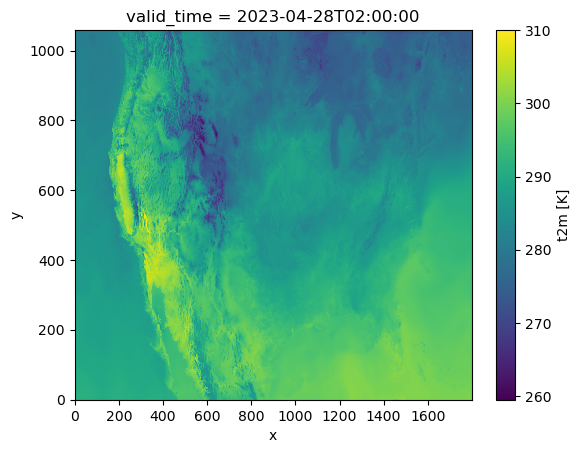

In [8]:
ds["t2m"][-1].plot()